<a href="https://colab.research.google.com/github/lorenzosintini/4YP/blob/master/Models_v3/VAE_Novel_NASA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## SETUP


#### Import and process data

Import Libraries

In [1]:
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
import random
import time
import os
import sys
from IPython.display import clear_output
import os
import pandas as pd
from sklearn.metrics import roc_curve, auc
from sklearn.utils import shuffle
from sklearn.utils import class_weight
tf.autograph.set_verbosity(0)
from google.colab import drive
from sys import getsizeof
drive.mount('/content/drive/')

TensorFlow 2.x selected.
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/



Plot data function

In [0]:
def plot_images(data, image_to_plot):
    plot = plt.figure(figsize=[15,2])
    for i in range(img_channels):
        plt.subplot(1, img_channels, i+1)
        plt.xticks([]); plt.yticks([])
        plt.imshow(data[image_to_plot][:,:,i], cmap=plt.cm.binary)
    plt.show()

Create dataset function







In [0]:
def setup_dataset(x):
  images = x/input_range

  batch_size = 100
  dataset = tf.data.Dataset.from_tensor_slices((images)).shuffle(len(images)).batch(batch_size)
  return dataset

def setup_dataset_no_shuffle(x):
  images = x/input_range

  batch_size = 100
  dataset = tf.data.Dataset.from_tensor_slices((images)).batch(batch_size)
  return dataset

#### Create Variational Autoencoder (VAE) Model

Make model

In [4]:
class CVAE(tf.keras.Model):
    def __init__(self, z_size):
        super(CVAE, self).__init__()
        self.z_size = z_size
        self.encoder_nn = tf.keras.models.Sequential([
                          tf.keras.layers.Input((64, 64, 6)),                          
                          tf.keras.layers.Conv2D(12, (7,7), strides = (1,1), padding = 'SAME', activation='relu'),
                          tf.keras.layers.Conv2D(8, (5,5), strides = (2,2), padding = 'SAME', activation='relu'),
                          tf.keras.layers.Conv2D(6, (3,3), strides = (2,2), padding = 'SAME', activation='relu'),
                          tf.keras.layers.Flatten(),
                          tf.keras.layers.Dense(z_size*2)
                          ], name='Encoder')

        self.decoder_nn = tf.keras.models.Sequential([
                          tf.keras.layers.Dense(768, activation='relu', input_shape=(z_size,)),
                          tf.keras.layers.Reshape(target_shape=(16, 16, 3)),
                          tf.keras.layers.Conv2DTranspose(8, (3,3), strides = (2,2), padding = 'SAME', activation='relu'),
                          tf.keras.layers.Conv2DTranspose(12, (5,5), strides = (2,2), padding = 'SAME'),
                          tf.keras.layers.Conv2DTranspose(6, (7,7), strides = (1,1), padding = 'SAME'),
                          ], name='Decoder')

    def encode(self, x):
        encoder_nn_output = self.encoder_nn(x)
        z_mean, z_logvar = tf.split(encoder_nn_output, num_or_size_splits=2, axis=1)
        return z_mean, z_logvar

    def reparameterize(self, z_mean, z_logvar):
        epsilon = tf.random.normal(shape=z_mean.shape)
        z_sampled = epsilon * tf.exp(z_logvar * 0.5) + z_mean
        return z_sampled
      
    def decode(self, z):
        pixel_output = self.decoder_nn(z)
        return pixel_output

model = CVAE(768)
model.encoder_nn.summary()
model.decoder_nn.summary()

Model: "Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 12)        3540      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 8)         2408      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 6)         438       
_________________________________________________________________
flatten (Flatten)            (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 1536)              2360832   
Total params: 2,367,218
Trainable params: 2,367,218
Non-trainable params: 0
_________________________________________________________________
Model: "Decoder"
_________________________________________________________________
Layer (type)                 Out

Define the loss function 

In [0]:
def calculate_ELBO(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  pixel_prob = tf.math.sigmoid(x_logit)

  variance = 0.2**2
  logpx_z = tf.reduce_sum(-.5 * (((x - pixel_prob) ** 2. / variance) + tf.math.log(variance * 2.0 * np.pi)), axis=[1, 2, 3])
  KL = -0.5*(tf.reduce_sum(tf.math.add(logvar,1), axis=1) - tf.reduce_sum(tf.exp(logvar), axis=1) - tf.reduce_sum(tf.exp(mean ** 2), axis=1))

  #print('recon = ' + str(tf.reduce_mean(logpx_z).numpy()))
  #print('KL = ' + str(tf.reduce_mean(KL).numpy()))

  return -tf.reduce_mean(logpx_z - KL)

Define the optimizer and metrics

In [0]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
train_loss = tf.keras.metrics.Mean(name='train_loss')
test_loss = tf.keras.metrics.Mean(name='test_loss')

Define train and test steps

In [0]:
def train_step(model, x, optimizer):
    with tf.GradientTape() as tape:
        loss = calculate_ELBO(model, x)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        train_loss(loss)

def test_step(model, x, optimizer):
    loss = calculate_ELBO(model, x)
    test_loss(loss)

def train_only_dataset(model, train_dataset, epochs):  
  for epoch in range(epochs):
    for train_x in train_dataset: 
      train_step(model, train_x, optimizer)

    loss = -train_loss.result()
     
  train_loss.reset_states()
  return loss

## TRAIN THE DATA

### Import and train the data

Import and randomize the data

In [8]:
IMPORT_NEW_DATA = 0

if IMPORT_NEW_DATA == 1:
  print('Importing new data...')
  typical_images = np.load('/content/drive/My Drive/SPACE_DATA/typical_images.npy')
  novel_images = np.load('/content/drive/My Drive/SPACE_DATA/novel_images.npy')

  test_idx = random.sample(range(0, 98800), 100)
  train_idx = list(range(98800))
  for i in test_idx:
    train_idx.remove(i)

  typical_images_train = typical_images[train_idx]
  typical_images_test = typical_images[test_idx]

  test_idx = random.sample(range(0, 332), 32)
  train_idx = list(range(332))
  for i in test_idx:
    train_idx.remove(i)

  novel_images_train = novel_images[train_idx]
  novel_images_test = novel_images[test_idx]

  np.save('/content/drive/My Drive/SPACE_DATA/typical_images_train.npy', typical_images_train)
  np.save('/content/drive/My Drive/SPACE_DATA/typical_images_test.npy', typical_images_test)
  np.save('/content/drive/My Drive/SPACE_DATA/novel_images_train.npy', novel_images_train)
  np.save('/content/drive/My Drive/SPACE_DATA/novel_images_test.npy', novel_images_test)

  typical_images = 0
  novel_images = 0

if IMPORT_NEW_DATA == 0:
  print('Importing old data...')
  typical_images_train = np.load('/content/drive/My Drive/SPACE_DATA/typical_images_train.npy')
  novel_images_train = np.load('/content/drive/My Drive/SPACE_DATA/novel_images_train.npy')
  typical_images_test = np.load('/content/drive/My Drive/SPACE_DATA/typical_images_test.npy')
  novel_images_test = np.load('/content/drive/My Drive/SPACE_DATA/novel_images_test.npy')

Importing old data...


Define image sizes and numbers

In [0]:
N_typical_images_train = typical_images_train.shape[0]
N_typical_images_test = typical_images_test.shape[0]
N_novel_images_train = novel_images_train.shape[0]
N_novel_images_test = novel_images_test.shape[0]
img_height = typical_images_train.shape[1]
img_width = typical_images_train.shape[2]
img_channels = typical_images_train.shape[3]
input_range = np.amax(typical_images_train)

Train the data

In [0]:
z_size = 768
model = CVAE(z_size)

5.90---> 15826.842


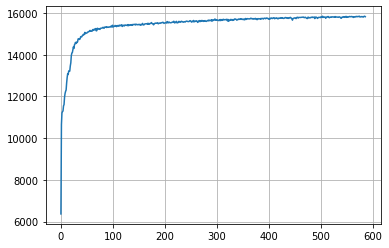

TRAINING TIME = 322.7310655117035



In [11]:
start_time = time.time()
losses = []
for j in range(6):
  typical_images_train = shuffle(typical_images_train, random_state=0)
  print(j)
  for i in range(99):
    train_dataset = setup_dataset(typical_images_train[i*1000:i*1000+1000].astype('float32'))
    loss = train_only_dataset(model, train_dataset, 1)
    losses = np.append(losses, loss.numpy())

    if i%10 == 0:
      clear_output()
      print(str(j) + '.' + str(i) + '---> ' + str(loss.numpy()))
      plt.plot(range(len(losses)), losses)
      plt.grid(which='both', axis='both')
      plt.show()
print('TRAINING TIME = {}\n'.format(time.time()-start_time))

### Check the model works

Reconstruct images

Original Pictures:


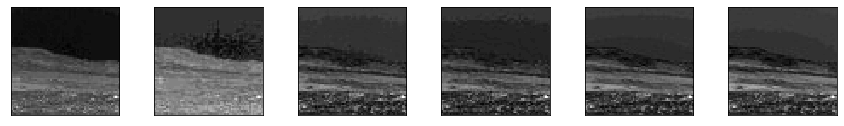

Reconstructed Pictures


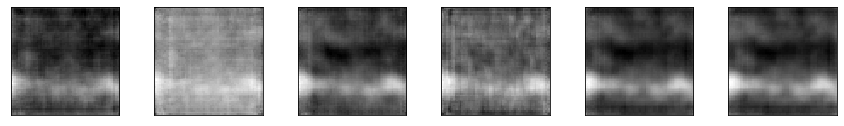

[16140.]


In [12]:
def reconstruct_images(model, data, images):
    images_n = 1
    x = data[images]/input_range
    x = x.reshape(images_n, img_height, img_width, img_channels).astype('float32')

    z_mean, z_logvar = model.encode(x)
    z = model.reparameterize(z_mean, z_logvar)
    pixel_output = model.decode(z)
    pixel_prob = tf.math.sigmoid(pixel_output)

    loss = np.empty([images_n])
    for i in range(images_n):
        loss[i] = -calculate_ELBO(model,x[i:i+1])
    loss = loss.astype('float16')
    
    print('Original Pictures:')
    plot_images(data, images)
    print('Reconstructed Pictures')
    plot_images(pixel_prob, 0)
    return loss

loss = reconstruct_images(model, typical_images_train, 0)
print(loss)

Visualize the latent space

0.9767251014709473


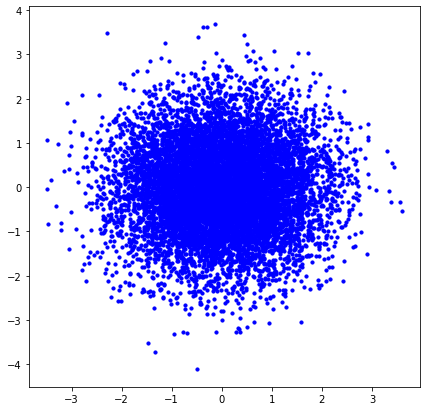

In [13]:
def visualize_latent_space(model, images, data_x, dimensions):
  plot = plt.figure(figsize=[7,7])
  outliers=0
  outlier = []
  data_x = data_x[images[0]:images[1]]
  latent_space = np.ndarray([0, model.z_size])
  for i in range((images[1]-images[0])//1000 +1):
      x = data_x[i*1000:i*1000+1000].astype('float32')
      x = x/input_range
      z_mean, z_logvar = model.encode(x)
      z = model.reparameterize(z_mean, z_logvar)
      latent_space = np.append(latent_space, z, axis=0)


  plt.scatter(latent_space[:, dimensions[0]], latent_space[:,dimensions[1]], color = 'blue', s=10)

  return latent_space, outlier

start_time = time.time()
latent_space, outlier = visualize_latent_space(model, [0, 10000], typical_images_train, [0,1])
print(time.time()-start_time)

## PREDICT NOVELTIES WITH THRESHOLD

#### Define novelty functions

Loss_1 = Deterministic reconstruction error

Loss_2 = Encoder-stochastic reconstruction error average

Loss_3 = Encoder-stochastic reconstruction error minimum

Loss_4 = Deterministic reconstruction likelihood

Loss_5 = Encoder-stochastic reconstruction likelihood average

Loss_6 = Encoder-stochastic reconstruction likelihood minimum

Loss_7 = Fully deterministic distance-based reconstruction error

Loss_8 = Test deterministic distance-based reconstruction error

Loss_9 = Train deterministic distance-based reconstruction error

Loss_10 = Bhattacharyya distance of deterministic reconstruction likelihood

Loss_11 = ELBO

Loss_12 = ELBO average

Loss_13 = ELBO minimum

Loss_14 = KL Divergence

Loss_15 = Euclidean distance between means of the distributions

Loss_16 = Bhattacharyya distance between distributions

Loss_17 = Density latent space 

In [0]:
def Loss_1(model, x):
  losses_per_image = []
  for images in x:

    z_mean, z_logvar = model.encode(images)
    pixel_prob = model.decode(z_mean)
    pixel_prob = tf.math.sigmoid(pixel_prob)

    pixel_squared = tf.math.square(pixel_prob - images)
    pixel_squared = tf.reduce_sum(pixel_squared, axis=[1,2,3])
    losses_per_image = np.append(losses_per_image, pixel_squared)
  return losses_per_image

def Loss_2(model, x):
  losses_per_image = []
  for images in x:

    z_mean, z_logvar = model.encode(images)
    avg = np.empty([25, len(images)])
    for j in range(25):
      z = model.reparameterize(z_mean, z_logvar)
      pixel_prob = model.decode(z)
      pixel_prob = tf.math.sigmoid(pixel_prob)

      pixel_squared = np.square(pixel_prob - images)
      pixel_squared = tf.reduce_sum(pixel_squared, axis=[1,2,3])
      avg[j,:] = pixel_squared
    losses_per_image = np.append(losses_per_image, np.mean(avg, axis=0))
  return losses_per_image

def Loss_3(model, x):
  losses_per_image = []
  for images in x:

    z_mean, z_logvar = model.encode(images)
    avg = np.empty([25, len(images)])
    for j in range(25):
      z = model.reparameterize(z_mean, z_logvar)
      pixel_prob = model.decode(z)
      pixel_prob = tf.math.sigmoid(pixel_prob)

      pixel_squared = np.square(pixel_prob - images)
      pixel_squared = tf.reduce_sum(pixel_squared, axis=[1,2,3])
      avg[j,:] = pixel_squared
    losses_per_image = np.append(losses_per_image, np.min(avg, axis=0))
  return losses_per_image

def Loss_4(model, x):
  losses_per_image = []
  for images in x:
    z_mean, z_logvar = model.encode(images)
    pixel_prob = model.decode(z_mean)
    pixel_prob = tf.math.sigmoid(pixel_prob)

    variance = 0.2**2
    logpx_z = tf.reduce_sum(-.5 * (((images - pixel_prob) ** 2. / variance) + tf.math.log(variance * 2.0 * 3.14)), axis=[1, 2, 3])
    losses_per_image = np.append(losses_per_image, logpx_z)
  return -losses_per_image

def Loss_5(model, x):
  losses_per_image = []
  for images in x:
    z_mean, z_logvar = model.encode(images)
    avg = np.empty([25, len(images)])
    for j in range(25):
      z = model.reparameterize(z_mean, z_logvar)
      pixel_prob = model.decode(z)
      pixel_prob = tf.math.sigmoid(pixel_prob)

      variance = 0.2**2
      logpx_z = tf.reduce_sum(-.5 * (((images - pixel_prob) ** 2. / variance) + tf.math.log(variance * 2.0 * np.pi)), axis=[1, 2, 3])
      avg[j,:] = logpx_z
    losses_per_image = np.append(losses_per_image, np.mean(avg, axis=0))
  return -losses_per_image

def Loss_6(model, x):
  losses_per_image = []
  for images in x:
    z_mean, z_logvar = model.encode(images)
    avg = np.empty([25, len(images)])
    for j in range(25):
      z = model.reparameterize(z_mean, z_logvar)
      pixel_prob = model.decode(z)
      pixel_prob = tf.math.sigmoid(pixel_prob)

      variance = 0.2**2
      logpx_z = tf.reduce_sum(-.5 * (((images - pixel_prob) ** 2. / variance) + tf.math.log(variance * 2.0 * np.pi)), axis=[1, 2, 3])
      avg[j,:] = logpx_z
    losses_per_image = np.append(losses_per_image, np.min(avg, axis=0))
  return -losses_per_image

def Loss_7(model, x_train, x_test):
  losses_per_image = []
  pixel_prob_per_image_train = np.empty([0,64,64,6])
  pixel_prob_per_image_test = np.empty([0,64,64,6])
  for images in x_train:
    z_mean, z_logvar = model.encode(images)
    pixel_prob = model.decode(z_mean)
    pixel_prob = tf.math.sigmoid(pixel_prob)
    pixel_prob_per_image_train = np.append(pixel_prob_per_image_train, pixel_prob, axis=0)
  for images in x_test:
    z_mean, z_logvar = model.encode(images)
    pixel_prob = model.decode(z_mean)
    pixel_prob = tf.math.sigmoid(pixel_prob)
    pixel_prob_per_image_test = np.append(pixel_prob_per_image_test, pixel_prob, axis=0) 
  num = len(pixel_prob_per_image_test)
  for i in range(num):
    #if not i%100: clear_output(); print('Progress Loss_7:{}%'.format(100*(i)/num))
    temporary = np.abs(pixel_prob_per_image_test[i] - pixel_prob_per_image_train)
    temporary = tf.reduce_sum(temporary, axis=[1,2,3])
    losses_per_image = np.append(losses_per_image, np.min(temporary))
  return losses_per_image

def Loss_8(model, x_train, x_test):
  losses_per_image = []
  image_train = np.empty([0,64,64,6])
  pixel_prob_per_image_test = np.empty([0,64,64,6])
  for images in x_train:
    image_train = np.append(image_train, images, axis=0)
  for images in x_test:
    z_mean, z_logvar = model.encode(images)
    pixel_prob = model.decode(z_mean)
    pixel_prob = tf.math.sigmoid(pixel_prob)
    pixel_prob_per_image_test = np.append(pixel_prob_per_image_test, pixel_prob, axis=0)
  num = len(pixel_prob_per_image_test)
  for i in range(num):
    #if not i%100: clear_output(); print('Progress Loss_9:{}%'.format(100*(i)/num))
    temporary = np.abs(pixel_prob_per_image_test[i] - image_train)
    temporary = tf.reduce_sum(temporary, axis=[1,2,3])
    losses_per_image = np.append(losses_per_image, np.min(temporary))
  return losses_per_image

def Loss_9(model, x_train, x_test):
  losses_per_image = []
  pixel_prob_per_image_train = np.empty([0,64,64,6])
  image_test = np.empty([0,64,64,6])
  for images in x_test:
    image_test = np.append(image_test, images, axis=0)
  for images in x_train:
    z_mean, z_logvar = model.encode(images)
    pixel_prob = model.decode(z_mean)
    pixel_prob = tf.math.sigmoid(pixel_prob)
    pixel_prob_per_image_train = np.append(pixel_prob_per_image_train, pixel_prob, axis=0)
  num = len(image_test)
  for i in range(num):
    #if not i%100: clear_output(); print('Progress Loss_9:{}%'.format(100*(i)/num))
    temporary = np.abs(image_test[i] - pixel_prob_per_image_train)
    temporary = tf.reduce_sum(temporary, axis=[1,2,3])
    losses_per_image = np.append(losses_per_image, np.min(temporary))
  return losses_per_image

def Loss_10(model, x_train, x_test):
  losses_per_image = []
  pixel_prob_per_image_train = np.empty([0,64,64,6])
  pixel_prob_per_image_test = np.empty([0,64,64,6])
  a = 0; b = 0
  for images in x_train:
    z_mean, z_logvar = model.encode(images)
    pixel_prob = model.decode(z_mean)
    pixel_prob = tf.math.sigmoid(pixel_prob)
    pixel_prob_per_image_train = np.append(pixel_prob_per_image_train, pixel_prob, axis=0)
  for images in x_test:
    z_mean, z_logvar = model.encode(images)
    pixel_prob = model.decode(z_mean)
    pixel_prob = tf.math.sigmoid(pixel_prob)
    pixel_prob_per_image_test = np.append(pixel_prob_per_image_test, pixel_prob, axis=0) 
  num = len(pixel_prob_per_image_test)
  for i in range(num):
    if not i%100: clear_output(); print('Progress Loss_8:{}%'.format(100*(i)/num))
    temporary = np.sqrt(np.multiply(1-pixel_prob_per_image_test[i],np.subtract(1,pixel_prob_per_image_train)))+np.sqrt(np.multiply(pixel_prob_per_image_test[i],pixel_prob_per_image_train))
    temporary = np.log(temporary)
    temporary = tf.reduce_sum(temporary, axis=[1,2,3])
    losses_per_image = np.append(losses_per_image, np.min(temporary))
  return losses_per_image

def Loss_11(model, x):
  losses_per_image = -Loss_4(model, x)-Loss_14(model, x)
  return -losses_per_image

def Loss_12(model, x):
  losses_per_image = -Loss_5(model, x)-Loss_14(model, x)
  return -losses_per_image

def Loss_13(model, x):
  losses_per_image = -Loss_6(model, x)-Loss_14(model, x)
  return -losses_per_image

def Loss_14(model, x):
  losses_per_image = []
  for images in x:
    z_mean, z_logvar = model.encode(images)

    KL = -0.5*(tf.reduce_sum(tf.math.add(z_logvar,1), axis=1) - tf.reduce_sum(tf.exp(z_logvar), axis=1) - tf.reduce_sum(tf.exp(z_mean ** 2), axis=1))
    losses_per_image = np.append(losses_per_image, KL)
  return -losses_per_image

def Loss_15(model, x_train, x_test):
  losses_per_image = []
  z_mean_per_image_train = []
  z_mean_per_image_test = []
  a = 0; b = 0
  for images in x_train:
    z_mean, z_logvar = model.encode(images)
    if a != 0: z_mean_per_image_train = np.append(z_mean_per_image_train, z_mean, axis=0)
    else: z_mean_per_image_train = z_mean; a = 1
  for images in x_test:
    z_mean, z_logvar = model.encode(images)
    if b != 0: z_mean_per_image_test = np.append(z_mean_per_image_test, z_mean, axis=0)
    else: z_mean_per_image_test = z_mean; b = 1 
  num = len(z_mean_per_image_test)
  for i in range(num):
    if not i%500: clear_output(); print('Progress Loss_15:{}%'.format(100*(i)/num))
    temporary = np.abs(z_mean_per_image_test[i] - z_mean_per_image_train)
    temporary = tf.reduce_sum(temporary, axis=1)
    losses_per_image = np.append(losses_per_image, np.min(temporary)) 
  return losses_per_image

def Loss_16(model, x_train, x_test):
  losses_per_image = []
  z_mean_train = []; z_var_train = []
  z_mean_test = []; z_var_test = []
  a = 0; b = 0
  for images in x_train:
    z_mean, z_logvar = model.encode(images)
    if a != 0: 
      z_mean_train = np.append(z_mean_train, z_mean, axis=0)
      z_var_train = np.append(z_var_train, np.exp(z_logvar), axis=0)
    else: 
      z_mean_train = z_mean
      z_var_train = np.exp(z_logvar)
      a = 1
  for images in x_test:
    z_mean, z_logvar = model.encode(images)
    if b != 0: 
      z_mean_test = np.append(z_mean_test, z_mean, axis=0)
      z_var_test = np.append(z_var_test, np.exp(z_logvar), axis=0)
    else: 
      z_mean_test = z_mean
      z_var_test = np.exp(z_logvar)
      b = 1 
  num = len(z_mean_test)
  for i in range(num):
    if not i%100: clear_output(); print('Progress Loss_16:{}%'.format(100*(i)/num))
    temporary_1 = np.log(np.multiply(0.25, (np.add(np.divide(z_var_test[i], z_var_train), np.add(np.divide(z_var_train, z_var_test[i]),2)))))
    temporary_2 = np.divide(np.square(np.subtract(z_mean_test[i], z_mean_train)), np.add(z_var_test[i], z_var_train))
    temporary = np.multiply(0.25, temporary_1) + np.multiply(0.25, temporary_2)
    losses_per_image = np.append(losses_per_image, np.min(np.sum(temporary)))
  return losses_per_image

def Loss_17(model, x_train, x_test):
  losses_per_image = []
  z_mean_train = []; z_var_train = []
  z_mean_test = []
  a = 0; b = 0
  for images in x_train:
    z_mean, z_logvar = model.encode(images)
    if a != 0: 
      z_mean_train = np.append(z_mean_train, z_mean, axis=0)
      z_var_train = np.append(z_var_train, np.exp(z_logvar), axis=0)
    else: 
      z_mean_train = z_mean
      z_var_train = np.exp(z_logvar)
      a = 1
  for images in x_test:
    z_mean, z_logvar = model.encode(images)
    if b != 0: z_mean_test = np.append(z_mean_test, z_mean, axis=0)
    else: z_mean_test = z_mean; b = 1 
  
  num = len(z_mean_test)
  for i in range(num):
    if not i%100: clear_output(); print('Progress Loss_17:{}%'.format(100*(i)/num))
    A = np.divide(0.39894, np.sqrt(z_var_train))
    B1 = np.subtract(z_mean_test[i], z_mean_train)
    B2 = np.sqrt(z_var_train)
    B = np.multiply(-0.5, np.square(np.divide(B1,B2)))
    temporary = np.multiply(A, np.exp(B))
    temporary = np.mean(temporary)
    losses_per_image = np.append(losses_per_image, temporary) 
  return -losses_per_image

In [0]:
Loss_functions_dict = dict([(1,Loss_1),(2,Loss_2),(3,Loss_3),(4,Loss_4),(5,Loss_5),(6,Loss_6),(7,Loss_7),
                            (8,Loss_8),(9,Loss_9),(10,Loss_10),(11,Loss_11),(12,Loss_12),(13,Loss_13),
                            (14,Loss_14),(15,Loss_15),(16,Loss_16),(17,Loss_17)])

### Classify with untrained ROC curve

In [0]:
def threshold_ROC(y_true, y_score, title, plot=True):
  fpr, tpr, threshold = roc_curve(y_true, y_score)
  roc_auc = auc(fpr, tpr)
  optimal_idx = np.argmin(np.sqrt(np.square(1-tpr) + np.square(fpr)))
  optimal_threshold = threshold[optimal_idx]

  optimal_accuracy_idx = np.argmax(tpr*300+((1-fpr)*98700))
  optimal_accuracy = (tpr[optimal_accuracy_idx]*300+((1-fpr[optimal_accuracy_idx])*98700))/99000
  optimal_accuracy_threshold = threshold[optimal_accuracy_idx]

  optimal_avgaccuracy_idx = np.argmax(tpr + 1 - fpr)
  optimal_avgaccuracy = (tpr[optimal_avgaccuracy_idx]+1-fpr[optimal_avgaccuracy_idx])/2
  optimal_avgaccuracy_threshold = threshold[optimal_avgaccuracy_idx]

  if plot:
    plot = plt.figure()
    plt.plot(fpr, tpr, color='red', label='AUC = %0.2f; Threshold = %0.4f' % (roc_auc,optimal_threshold))
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve for ' + title)
    plt.legend(loc="lower right")
    plt.show()
  return roc_auc, optimal_threshold, optimal_accuracy, optimal_accuracy_threshold, optimal_avgaccuracy, optimal_avgaccuracy_threshold

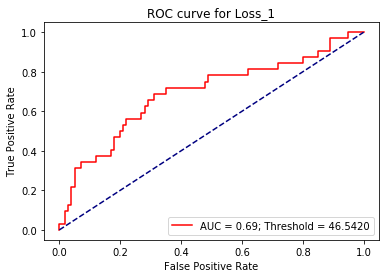

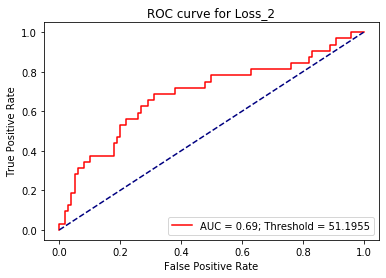

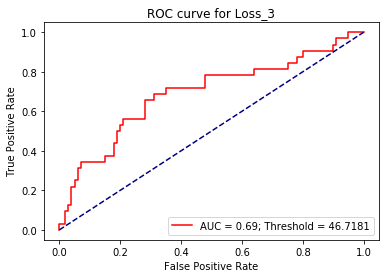

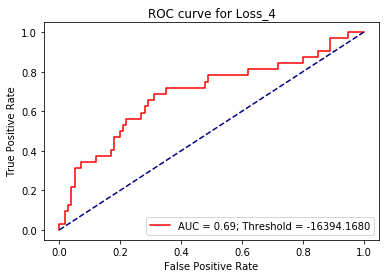

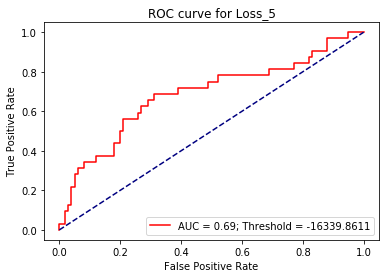

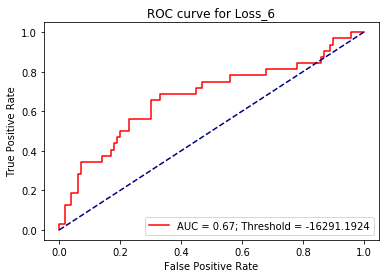

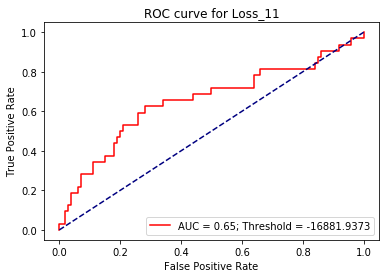

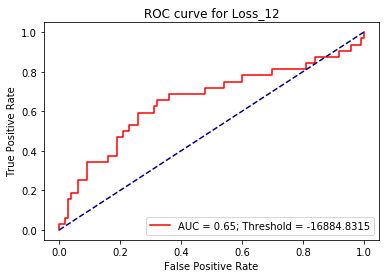

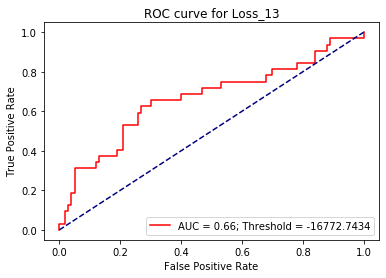

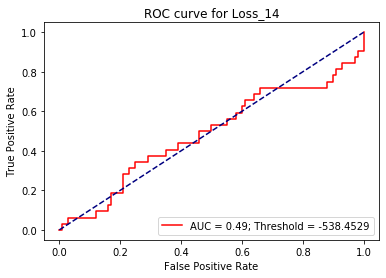

In [20]:
threshold_dict = dict([])
threshold_avg_dict = dict([])
auc_dict = dict([])
y_predicted_dict = dict([])

table_of_counts_dict = dict([])
accuracy_dict = dict([])
avg_accuracy_dict = dict([])

for i in [1, 2, 3, 4, 5, 6, 11, 12, 13, 14]:
    dataset = setup_dataset(novel_images_test.astype('float32'))
    losses = Loss_functions_dict[i](model, dataset)
    dataset = setup_dataset(typical_images_test.astype('float32'))
    losses = np.append(losses, Loss_functions_dict[i](model, dataset))
    y_true = np.zeros([len(losses),])
    y_true[0:32] = 1
    auc_dict[i], threshold_dict[i], _, _, _, threshold_avg_dict[i] = threshold_ROC(y_true, losses, 'Loss_'+str(i), plot=True)
    y_predicted_dict[i] = np.zeros([len(losses),])
    y_predicted_dict[i][np.where(losses > threshold_dict[i])] = 1 

    table_of_counts = np.zeros([2,2])
    for j in range(len(losses),):
      if y_true[j] == 0:
        if y_predicted_dict[i][j] == 0:
          table_of_counts[0,0] += 1
        else: table_of_counts[0,1] += 1
      if y_true[j] == 1:
        if y_predicted_dict[i][j] == 0:
          table_of_counts[1,0] += 1
        else: table_of_counts[1,1] += 1

    true_positive = table_of_counts[1,1]
    false_positive = table_of_counts[0,1]
    true_negative = table_of_counts[0,0]
    false_negative = table_of_counts[1,0]

    accuracy = (true_positive+true_negative)/len(losses)
    avg_accuracy = np.mean([true_positive/(true_positive+false_negative),true_negative/(true_negative+false_positive)])

    table_of_counts_dict[i] = table_of_counts
    accuracy_dict[i] = accuracy
    avg_accuracy_dict[i] = avg_accuracy

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


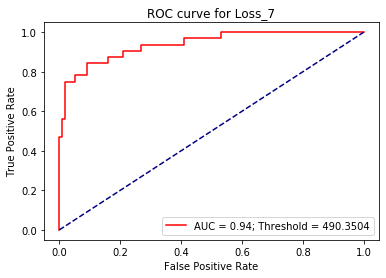

1959.2314403057098
[[91.  9.]
 [ 6. 26.]]
0.93875


In [21]:
for i in [7]:
    start_time= time.time()
    temp = np.empty([20,32])
    dataset1 = setup_dataset_no_shuffle(novel_images_test.astype('float32'))
    for j in range(20):
      print(j)
      dataset2 = setup_dataset_no_shuffle(typical_images_train[5000*j:5000*j+5000].astype('float32'))
      temp[j,:] = Loss_functions_dict[i](model, dataset2, dataset1)
    losses = np.min(temp, axis=0)

    temp = np.empty([20,100])
    dataset1 = setup_dataset_no_shuffle(typical_images_test.astype('float32'))
    for j in range(20):
      print(j)
      dataset2 = setup_dataset_no_shuffle(typical_images_train[5000*j:5000*j+5000].astype('float32'))
      temp[j,:] = Loss_functions_dict[i](model, dataset2, dataset1)
    losses = np.append(losses, np.min(temp, axis=0))

    y_true = np.zeros([len(losses),])
    y_true[0:32] = 1
    auc_dict[i], threshold_dict[i], _, _, _, threshold_avg_dict[i] = threshold_ROC(y_true, losses, 'Loss_'+str(i), plot=True)
    y_predicted_dict[i] = np.zeros([len(losses),])
    y_predicted_dict[i][np.where(losses > threshold_dict[i])] = 1 

    table_of_counts = np.zeros([2,2])
    for j in range(len(losses),):
      if y_true[j] == 0:
        if y_predicted_dict[i][j] == 0:
          table_of_counts[0,0] += 1
        else: table_of_counts[0,1] += 1
      if y_true[j] == 1:
        if y_predicted_dict[i][j] == 0:
          table_of_counts[1,0] += 1
        else: table_of_counts[1,1] += 1

    true_positive = table_of_counts[1,1]
    false_positive = table_of_counts[0,1]
    true_negative = table_of_counts[0,0]
    false_negative = table_of_counts[1,0]

    accuracy = (true_positive+true_negative)/len(losses)
    avg_accuracy = np.mean([true_positive/(true_positive+false_negative),true_negative/(true_negative+false_positive)])

    table_of_counts_dict[i] = table_of_counts
    accuracy_dict[i] = accuracy
    avg_accuracy_dict[i] = avg_accuracy
    print(time.time()-start_time)
    print(table_of_counts_dict[i])
    print(auc_dict[i])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


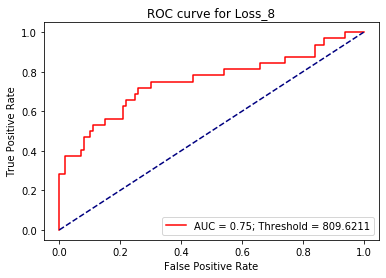

1936.6672809123993
[[74. 26.]
 [10. 22.]]
0.7509375


In [22]:
for i in [8]:
    start_time= time.time()
    temp = np.empty([20,32])
    dataset1 = setup_dataset_no_shuffle(novel_images_test.astype('float32'))
    for j in range(20):
      print(j)
      dataset2 = setup_dataset_no_shuffle(typical_images_train[5000*j:5000*j+5000].astype('float32'))
      temp[j,:] = Loss_functions_dict[i](model, dataset2, dataset1)
    losses = np.min(temp, axis=0)

    temp = np.empty([20,100])
    dataset1 = setup_dataset_no_shuffle(typical_images_test.astype('float32'))
    for j in range(20):
      print(j)
      dataset2 = setup_dataset_no_shuffle(typical_images_train[5000*j:5000*j+5000].astype('float32'))
      temp[j,:] = Loss_functions_dict[i](model, dataset2, dataset1)
    losses = np.append(losses, np.min(temp, axis=0))

    y_true = np.zeros([len(losses),])
    y_true[0:32] = 1
    auc_dict[i], threshold_dict[i], _, _, _, threshold_avg_dict[i] = threshold_ROC(y_true, losses, 'Loss_'+str(i), plot=True)
    y_predicted_dict[i] = np.zeros([len(losses),])
    y_predicted_dict[i][np.where(losses > threshold_dict[i])] = 1 

    table_of_counts = np.zeros([2,2])
    for j in range(len(losses),):
      if y_true[j] == 0:
        if y_predicted_dict[i][j] == 0:
          table_of_counts[0,0] += 1
        else: table_of_counts[0,1] += 1
      if y_true[j] == 1:
        if y_predicted_dict[i][j] == 0:
          table_of_counts[1,0] += 1
        else: table_of_counts[1,1] += 1

    true_positive = table_of_counts[1,1]
    false_positive = table_of_counts[0,1]
    true_negative = table_of_counts[0,0]
    false_negative = table_of_counts[1,0]

    accuracy = (true_positive+true_negative)/len(losses)
    avg_accuracy = np.mean([true_positive/(true_positive+false_negative),true_negative/(true_negative+false_positive)])

    table_of_counts_dict[i] = table_of_counts
    accuracy_dict[i] = accuracy
    avg_accuracy_dict[i] = avg_accuracy
    print(time.time()-start_time)
    print(table_of_counts_dict[i])
    print(auc_dict[i])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


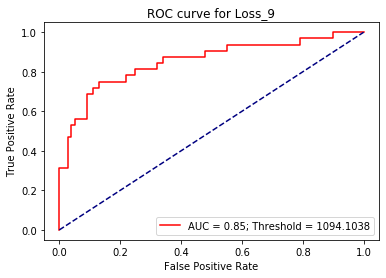

1958.9854078292847
[[87. 13.]
 [ 9. 23.]]
0.8521875


In [23]:
for i in [9]:
    start_time= time.time()
    temp = np.empty([20,32])
    dataset1 = setup_dataset_no_shuffle(novel_images_test.astype('float32'))
    for j in range(20):
      print(j)
      dataset2 = setup_dataset_no_shuffle(typical_images_train[5000*j:5000*j+5000].astype('float32'))
      temp[j,:] = Loss_functions_dict[i](model, dataset2, dataset1)
    losses = np.min(temp, axis=0)

    temp = np.empty([20,100])
    dataset1 = setup_dataset_no_shuffle(typical_images_test.astype('float32'))
    for j in range(20):
      print(j)
      dataset2 = setup_dataset_no_shuffle(typical_images_train[5000*j:5000*j+5000].astype('float32'))
      temp[j,:] = Loss_functions_dict[i](model, dataset2, dataset1)
    losses = np.append(losses, np.min(temp, axis=0))

    y_true = np.zeros([len(losses),])
    y_true[0:32] = 1
    auc_dict[i], threshold_dict[i], _, _, _, threshold_avg_dict[i] = threshold_ROC(y_true, losses, 'Loss_'+str(i), plot=True)
    y_predicted_dict[i] = np.zeros([len(losses),])
    y_predicted_dict[i][np.where(losses > threshold_dict[i])] = 1 

    table_of_counts = np.zeros([2,2])
    for j in range(len(losses),):
      if y_true[j] == 0:
        if y_predicted_dict[i][j] == 0:
          table_of_counts[0,0] += 1
        else: table_of_counts[0,1] += 1
      if y_true[j] == 1:
        if y_predicted_dict[i][j] == 0:
          table_of_counts[1,0] += 1
        else: table_of_counts[1,1] += 1

    true_positive = table_of_counts[1,1]
    false_positive = table_of_counts[0,1]
    true_negative = table_of_counts[0,0]
    false_negative = table_of_counts[1,0]

    accuracy = (true_positive+true_negative)/len(losses)
    avg_accuracy = np.mean([true_positive/(true_positive+false_negative),true_negative/(true_negative+false_positive)])

    table_of_counts_dict[i] = table_of_counts
    accuracy_dict[i] = accuracy
    avg_accuracy_dict[i] = avg_accuracy
    print(time.time()-start_time)
    print(table_of_counts_dict[i])
    print(auc_dict[i])

In [24]:
for i in [10]:
    start_time= time.time()
    temp = np.empty([20,32])
    dataset1 = setup_dataset_no_shuffle(novel_images_test.astype('float32'))
    for j in range(20):
      print(j)
      dataset2 = setup_dataset_no_shuffle(typical_images_train[5000*j:5000*j+5000].astype('float32'))
      temp[j,:] = Loss_functions_dict[i](model, dataset2, dataset1)
    losses = np.min(temp, axis=0)

    temp = np.empty([20,100])
    dataset1 = setup_dataset_no_shuffle(typical_images_test.astype('float32'))
    for j in range(20):
      print(j)
      dataset2 = setup_dataset_no_shuffle(typical_images_train[5000*j:5000*j+5000].astype('float32'))
      temp[j,:] = Loss_functions_dict[i](model, dataset2, dataset1)
    losses = np.append(losses, np.min(temp, axis=0))

    y_true = np.zeros([len(losses),])
    y_true[0:32] = 1
    auc_dict[i], threshold_dict[i], _, _, _, threshold_avg_dict[i] = threshold_ROC(y_true, losses, 'Loss_'+str(i), plot=True)
    y_predicted_dict[i] = np.zeros([len(losses),])
    y_predicted_dict[i][np.where(losses > threshold_dict[i])] = 1 

    table_of_counts = np.zeros([2,2])
    for j in range(len(losses),):
      if y_true[j] == 0:
        if y_predicted_dict[i][j] == 0:
          table_of_counts[0,0] += 1
        else: table_of_counts[0,1] += 1
      if y_true[j] == 1:
        if y_predicted_dict[i][j] == 0:
          table_of_counts[1,0] += 1
        else: table_of_counts[1,1] += 1

    true_positive = table_of_counts[1,1]
    false_positive = table_of_counts[0,1]
    true_negative = table_of_counts[0,0]
    false_negative = table_of_counts[1,0]

    accuracy = (true_positive+true_negative)/len(losses)
    avg_accuracy = np.mean([true_positive/(true_positive+false_negative),true_negative/(true_negative+false_positive)])

    table_of_counts_dict[i] = table_of_counts
    accuracy_dict[i] = accuracy
    avg_accuracy_dict[i] = avg_accuracy
    print(time.time()-start_time)
    print(table_of_counts_dict[i])
    print(auc_dict[i])

Progress Loss_8:0.0%


KeyboardInterrupt: ignored

In [27]:
result_table = np.empty([13,7])
index = ['_']*13
j = 0
for i in [1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14]:
  result_table[j,0] = "{0:.1f}".format(accuracy_dict[i]*100)
  result_table[j,1] = "{0:.1f}".format(avg_accuracy_dict[i]*100)
  result_table[j,2] = table_of_counts_dict[i][1,1].astype('int')
  result_table[j,3] = table_of_counts_dict[i][0,1].astype('int')
  result_table[j,4] = table_of_counts_dict[i][0,0].astype('int')
  result_table[j,5] = table_of_counts_dict[i][1,0].astype('int')
  result_table[j,6] = "{0:.1f}".format(auc_dict[i]*100)
  index[j] = 'Loss_'+str(i)
  j +=1
df = pd.DataFrame(result_table, index=index, columns = ['Accuracy', 'Avg_accuracy', 'True Pos.', 'False Pos.', 'True neg.', 'False Neg.', 'AUC',])
df.astype(str).replace('\.0', '', regex=True)

,Accuracy,Avg_accuracy,True Pos.,False Pos.,True neg.,False Neg.,AUC
Loss_1,68.2,67.3,21,31,69,11,69.1
Loss_2,68.2,67.3,21,31,69,11,68.8
Loss_3,68.2,67.3,21,31,69,11,69
Loss_4,68.2,67.3,21,31,69,11,69.1
Loss_5,68.2,67.3,21,31,69,11,68.5
Loss_6,66.7,66.3,21,33,67,11,67.3
Loss_7,88.6,86.1,26,9,91,6,93.9
Loss_8,72.7,71.4,22,26,74,10,75.1
Loss_9,83.3,79.4,23,13,87,9,85.2
Loss_11,68.9,65.7,19,28,72,13,65.2


### Compute novelty scores for training images

In [0]:
losses_typical = dict([])
losses_novel = dict([])

for j in [1, 2, 3, 4, 5, 6, 11, 12, 13, 14]:
  start_time = time.time()

  losses_typical[j] = []
  print('LOSS {} Pogress/20: '.format(j), end='')
  for i in range(20):
    print('{}, '.format(i+1), end='')
    dataset = setup_dataset(typical_images_train[i*5000:i*5000+5000].astype('float32'))
    losses_typical[j] = np.append(losses_typical[j], Loss_functions_dict[j](model, dataset))

  print('novel')
  dataset = setup_dataset(novel_images_train.astype('float32'))
  losses_novel[j] = Loss_functions_dict[j](model, dataset)

  print('LOSS {} Time ---> {} sec \n'.format(j, time.time()-start_time))

LOSS 1 Pogress/20: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, novel
LOSS 1 Time ---> 37.11826682090759 sec 

LOSS 2 Pogress/20: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, novel
LOSS 2 Time ---> 554.8263549804688 sec 

LOSS 3 Pogress/20: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, novel
LOSS 3 Time ---> 552.7745263576508 sec 

LOSS 4 Pogress/20: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, novel
LOSS 4 Time ---> 36.824498414993286 sec 

LOSS 5 Pogress/20: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, novel
LOSS 5 Time ---> 334.6028435230255 sec 

LOSS 6 Pogress/20: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, novel
LOSS 6 Time ---> 342.05461168289185 sec 

LOSS 11 Pogress/20: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, novel
LOSS 11 Time ---> 58.14826965332031 sec 

LOSS 12 Pogress/20: 1, 2, 3, 4, 5, 6,

In [0]:
np.save('/content/drive/My Drive/SPACE_DATA/losses_typical_dict.npy',losses_typical)
np.save('/content/drive/My Drive/SPACE_DATA/losses_novel_dict.npy',losses_novel)

In [0]:
losses_typical_dict = np.load('/content/drive/My Drive/SPACE_DATA/losses_typical_dict.npy', allow_pickle=True)
losses_typical_dict = losses_typical_dict.item()
losses_novel_dict = np.load('/content/drive/My Drive/SPACE_DATA/losses_novel_dict.npy', allow_pickle=True)
losses_novel_dict = losses_novel_dict.item()

### Classify with trained ROC curve

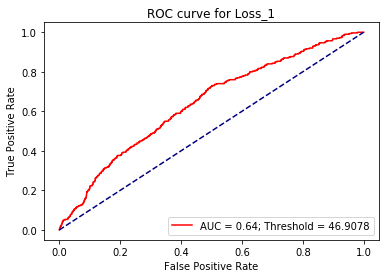

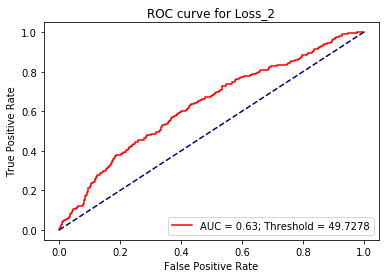

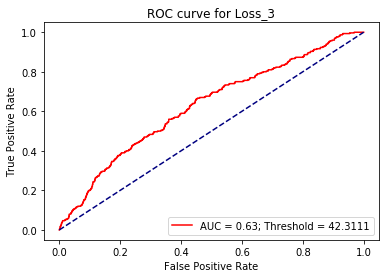

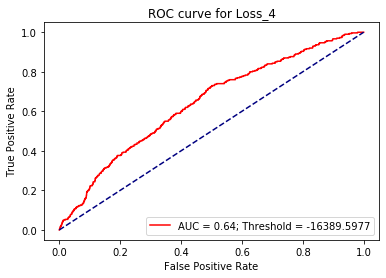

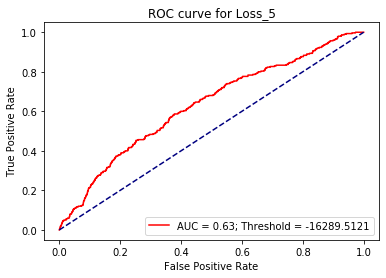

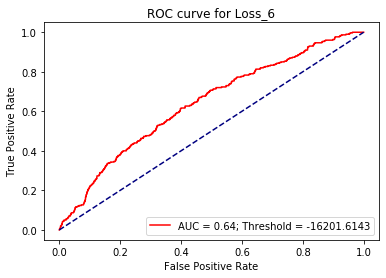

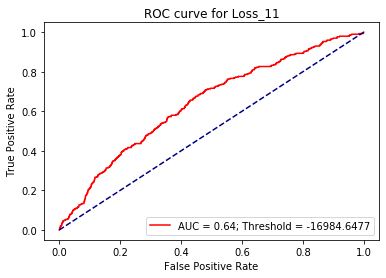

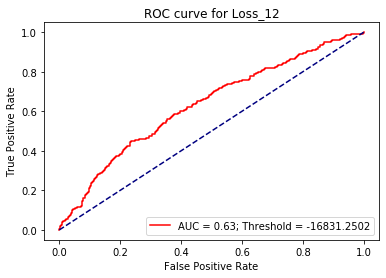

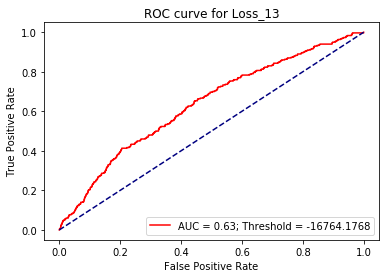

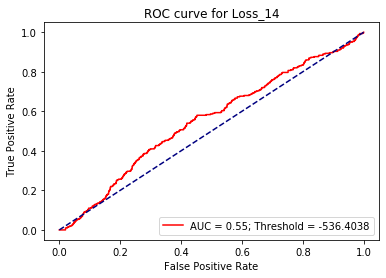

In [0]:
threshold_dict = dict([])
threshold_avg_dict = dict([])
auc_dict = dict([])
y_predicted_dict = dict([])

table_of_counts_dict = dict([])
accuracy_dict = dict([])
avg_accuracy_dict = dict([])

for i in [1, 2, 3, 4, 5, 6, 11, 12, 13, 14]:
    y_train = np.zeros([len(losses_novel_dict[1])+len(losses_typical_dict[1]),])
    y_train[0:300] = 1
    losses_train = np.append(losses_novel_dict[i], losses_typical_dict[i])
    auc_dict[i], threshold_dict[i], _, _, _, threshold_avg_dict[i] = threshold_ROC(y_train, losses_train, 'Loss_'+str(i), plot=True)

    dataset = setup_dataset(novel_images_test.astype('float32'))
    losses = Loss_functions_dict[i](model, dataset)
    dataset = setup_dataset(typical_images_test.astype('float32'))
    losses = np.append(losses, Loss_functions_dict[i](model, dataset))
    y_true = np.zeros([len(losses),])
    y_true[0:32] = 1
    y_predicted_dict[i] = np.zeros([len(losses),])
    y_predicted_dict[i][np.where(losses > threshold_avg_dict[i])] = 1 

    table_of_counts = np.zeros([2,2])
    for j in range(len(losses),):
      if y_true[j] == 0:
        if y_predicted_dict[i][j] == 0:
          table_of_counts[0,0] += 1
        else: table_of_counts[0,1] += 1
      if y_true[j] == 1:
        if y_predicted_dict[i][j] == 0:
          table_of_counts[1,0] += 1
        else: table_of_counts[1,1] += 1

    true_positive = table_of_counts[1,1]
    false_positive = table_of_counts[0,1]
    true_negative = table_of_counts[0,0]
    false_negative = table_of_counts[1,0]

    accuracy = (true_positive+true_negative)/len(losses)
    avg_accuracy = np.mean([true_positive/(true_positive+false_negative),true_negative/(true_negative+false_positive)])

    table_of_counts_dict[i] = table_of_counts
    accuracy_dict[i] = accuracy
    avg_accuracy_dict[i] = avg_accuracy

In [0]:
result_table = np.empty([10,7])
index = ['_']*10
j = 0
for i in [1, 2, 3, 4, 5, 6, 11, 12, 13, 14]:
  result_table[j,0] = "{0:.1f}".format(accuracy_dict[i]*100)
  result_table[j,1] = "{0:.1f}".format(avg_accuracy_dict[i]*100)
  result_table[j,2] = table_of_counts_dict[i][1,1].astype('int')
  result_table[j,3] = table_of_counts_dict[i][0,1].astype('int')
  result_table[j,4] = table_of_counts_dict[i][0,0].astype('int')
  result_table[j,5] = table_of_counts_dict[i][1,0].astype('int')
  result_table[j,6] = "{0:.2f}".format(auc_dict[i]*100)
  index[j] = 'Loss_'+str(i)
  j +=1
df = pd.DataFrame(result_table, index=index, columns = ['Accuracy', 'Avg_accuracy', 'True Pos.', 'False Pos.', 'True neg.', 'False Neg.', 'AUC',])
df.astype(str).replace('\.0', '', regex=True)

,Accuracy,Avg_accuracy,True Pos.,False Pos.,True neg.,False Neg.,AUC
Loss_1,62.1,67.6,25,43,57,7,63.96
Loss_2,67.4,67.9,22,33,67,10,631
Loss_3,65.2,67.4,23,37,63,9,62.78
Loss_4,62.1,67.6,25,43,57,7,63.96
Loss_5,69.7,68.3,21,29,71,11,631
Loss_6,68.2,67.3,21,31,69,11,63.84
Loss_11,61.4,67.1,25,44,56,7,649
Loss_12,72.7,60.7,12,16,84,20,63.18
Loss_13,72,58.1,10,15,85,22,63.41
Loss_14,39.4,50.4,23,71,29,9,55.22


### Classify using classifier

In [0]:
threshold_dict = dict([])
threshold_avg_dict = dict([])
auc_dict = dict([])
y_predicted_dict = dict([])
predictions_dict = dict([])

table_of_counts_dict = dict([])
accuracy_dict = dict([])
avg_accuracy_dict = dict([])

start_time = time.time()
for i in [1, 2, 3, 4, 5, 6, 11, 12, 13, 14]:
    print('TRAINING MODEL WITH LOSS ' + str(i))
    classifier = tf.keras.models.Sequential([
        tf.keras.layers.Dense(128, activation='relu', input_shape=(1,)),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])

    y_train = np.zeros([len(losses_novel_dict[1])+len(losses_typical_dict[1]),])
    y_train[0:300] = 1
    losses_train = np.append(losses_novel_dict[i], losses_typical_dict[i])
    losses_train=losses_train/np.max(losses_train)

    class_weights = dict(enumerate(class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)))
    classifier.fit(losses_train, y_train, batch_size=100, epochs=10, class_weight=class_weights, shuffle=True)

    dataset = setup_dataset(novel_images_test.astype('float32'))
    losses_test = Loss_functions_dict[i](model, dataset)
    dataset = setup_dataset(typical_images_test.astype('float32'))
    losses_test = np.append(losses_test, Loss_functions_dict[i](model, dataset))
    losses_test = losses_test/np.max(losses_test)
    predictions_dict[i] = classifier.predict(losses_test)
    predictions_dict[i] = predictions_dict[i].reshape([len(predictions)])
print('TRAINING TIME = {}\n'.format(time.time()-start_time))

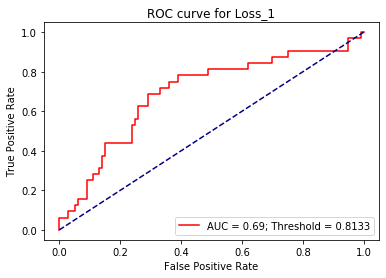

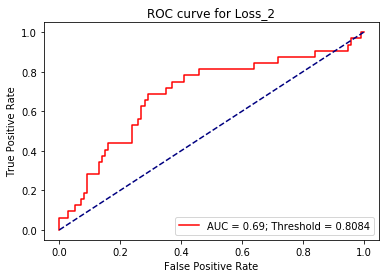

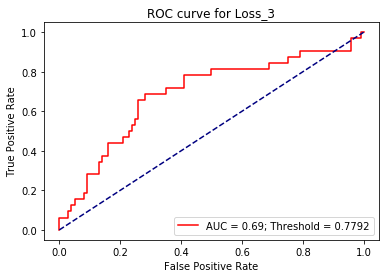

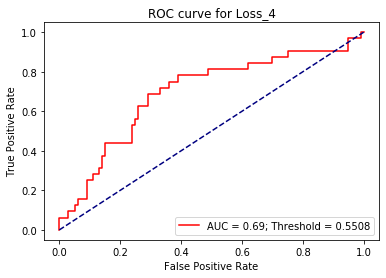

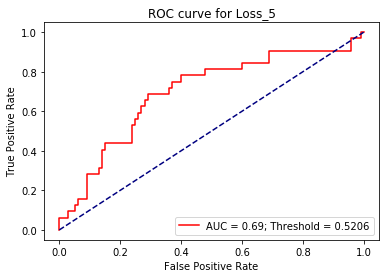

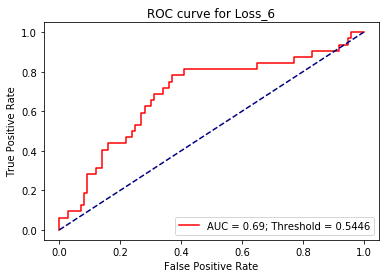

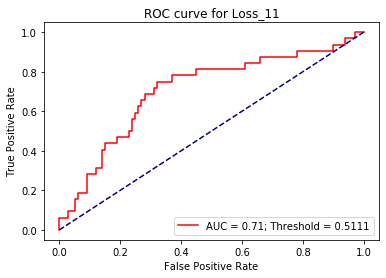

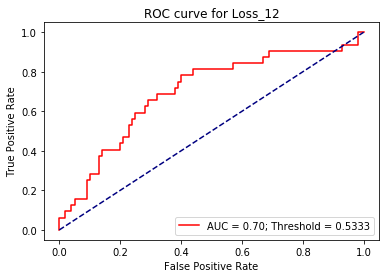

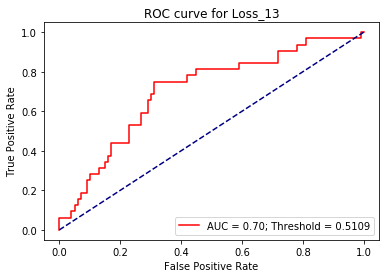

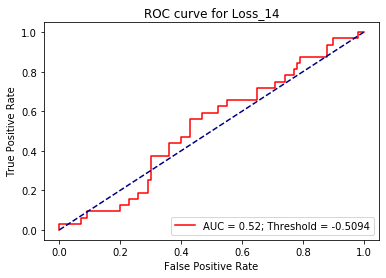

In [0]:
for i in [1, 2, 3, 4, 5, 6, 11, 12, 13, 14]:  
    y_true = np.zeros([len(losses_test),])
    y_true[0:32] = 1
    if i == 14:
      predictions_dict[i] = -predictions_dict[i]
    
    auc_dict[i], threshold_dict[i], _, _, _, threshold_avg_dict[i] = threshold_ROC(y_true, predictions_dict[i], 'Loss_'+str(i), plot=True)      

    y_predicted_dict[i] = np.zeros([len(predictions_dict[i]),])
    y_predicted_dict[i][np.where(predictions_dict[i] > threshold_avg_dict[i])] = 1 

    table_of_counts = np.zeros([2,2])
    for j in range(len(losses_test),):
      if y_true[j] == 0:
        if y_predicted_dict[i][j] == 0:
          table_of_counts[0,0] += 1
        else: table_of_counts[0,1] += 1
      if y_true[j] == 1:
        if y_predicted_dict[i][j] == 0:
          table_of_counts[1,0] += 1
        else: table_of_counts[1,1] += 1

    true_positive = table_of_counts[1,1]
    false_positive = table_of_counts[0,1]
    true_negative = table_of_counts[0,0]
    false_negative = table_of_counts[1,0]

    accuracy = (true_positive+true_negative)/len(losses_test)
    avg_accuracy = np.mean([true_positive/(true_positive+false_negative),true_negative/(true_negative+false_positive)])

    table_of_counts_dict[i] = table_of_counts
    accuracy_dict[i] = accuracy
    avg_accuracy_dict[i] = avg_accuracy

In [0]:
result_table = np.empty([10,7])
index = ['_']*10
j = 0
for i in [1, 2, 3, 4, 5, 6, 11, 12, 13, 14]:
  result_table[j,0] = "{0:.1f}".format(accuracy_dict[i]*100)
  result_table[j,1] = "{0:.1f}".format(avg_accuracy_dict[i]*100)
  result_table[j,2] = table_of_counts_dict[i][1,1].astype('int')
  result_table[j,3] = table_of_counts_dict[i][0,1].astype('int')
  result_table[j,4] = table_of_counts_dict[i][0,0].astype('int')
  result_table[j,5] = table_of_counts_dict[i][1,0].astype('int')
  result_table[j,6] = "{0:.1f}".format(auc_dict[i]*100)
  index[j] = 'Loss_'+str(i)
  j +=1
df = pd.DataFrame(result_table, index=index, columns = ['Accuracy', 'Avg_accuracy', 'True Pos.', 'False Pos.', 'True neg.', 'False Neg.', 'AUC',])
df.astype(str).replace('\.0', '', regex=True)

,Accuracy,Avg_accuracy,True Pos.,False Pos.,True neg.,False Neg.,AUC
Loss_1,69.7,68.3,21,29,71,11,69.3
Loss_2,69.7,68.3,21,29,71,11,68.8
Loss_3,70.5,68.8,21,28,72,11,68.8
Loss_4,69.7,68.3,21,29,71,11,69.3
Loss_5,69.7,68.3,21,29,71,11,69.5
Loss_6,65.9,69,24,37,63,8,69
Loss_11,68.9,69.9,23,32,68,9,70.6
Loss_12,63.6,67.5,24,40,60,8,69.7
Loss_13,69.7,70.4,23,31,69,9,70.3
Loss_14,56.1,55.1,17,43,57,15,52.2


## PREDICT NOVELTIES WITH NN

### Define novelty functions

Loss_1_img = Deterministic reconstruction map

Loss_2 = Encoder-stochastic reconstruction error average

Loss_3 = Encoder-stochastic reconstruction error minimum

Loss_4 = Deterministic reconstruction likelihood

Loss_5 = Encoder-stochastic reconstruction likelihood average

Loss_6 = Encoder-stochastic reconstruction likelihood minimum

Loss_7 = Fully deterministic distance-based reconstruction error

Loss_8 = Test deterministic distance-based reconstruction error

Loss_9 = Train deterministic distance-based reconstruction error

Loss_10 = Bhattacharyya distance of deterministic reconstruction likelihood

Loss_11 = ELBO

Loss_12 = ELBO average

Loss_13 = ELBO minimum

Loss_14 = KL Divergence

Loss_15 = Euclidean distance between means of the distributions

Loss_16 = Bhattacharyya distance between distributions

Loss_17 = Density latent space 

In [0]:
def Loss_1_img(model, x):
  losses_per_image = np.empty((0, 64, 64, 6))
  for images in x:
    z_mean, z_logvar = model.encode(images)
    pixel_prob = model.decode(z_mean)
    pixel_squared = np.square(pixel_prob - images)
    losses_per_image = np.append(losses_per_image, pixel_squared, axis=0)
  return losses_per_image

def Loss_2(model, x):
  losses_per_image = []
  for images in x:
    z_mean, z_logvar = model.encode(images)
    avg = np.empty([50, len(images)])
    for j in range(50):
      z = model.reparameterize(z_mean, z_logvar)
      pixel_prob = model.decode(z)
      pixel_squared = np.square(pixel_prob - images)
      pixel_squared = tf.reduce_sum(pixel_squared, axis=[1,2,3])
      avg[j,:] = pixel_squared
    losses_per_image = np.append(losses_per_image, np.mean(avg, axis=0))
  return losses_per_image

def Loss_3(model, x):
  losses_per_image = []
  for images in x:
    z_mean, z_logvar = model.encode(images)
    avg = np.empty([50, len(images)])
    for j in range(50):
      z = model.reparameterize(z_mean, z_logvar)
      pixel_prob = model.decode(z)
      pixel_squared = np.square(pixel_prob - images)
      pixel_squared = tf.reduce_sum(pixel_squared, axis=[1,2,3])
      avg[j,:] = pixel_squared
    losses_per_image = np.append(losses_per_image, np.min(avg, axis=0))
  return losses_per_image

def Loss_4(model, x):
  losses_per_image = []
  for images in x:
    z_mean, z_logvar = model.encode(images)
    pixel_prob = model.decode(z_mean)
    logpx_z_pixels = tf.math.log(pixel_prob + 1e-10)*images + tf.math.log(1-pixel_prob + 1e-10)*(1-images)
    logpx_z_images = -tf.reduce_sum(logpx_z_pixels, axis=[1, 2, 3])
    losses_per_image = np.append(losses_per_image, logpx_z_images)
  return losses_per_image

def Loss_5(model, x):
  losses_per_image = []
  for images in x:
    z_mean, z_logvar = model.encode(images)
    avg = np.empty([50, len(images)])
    for j in range(50):
      z = model.reparameterize(z_mean, z_logvar)
      pixel_prob = model.decode(z)
      logpx_z_pixels = tf.math.log(pixel_prob + 1e-10)*images + tf.math.log(1-pixel_prob + 1e-10)*(1-images)
      logpx_z_images = -tf.reduce_sum(logpx_z_pixels, axis=[1, 2, 3])
      avg[j,:] = logpx_z_images
    losses_per_image = np.append(losses_per_image, np.mean(avg, axis=0))
  return losses_per_image

def Loss_6(model, x):
  losses_per_image = []
  for images in x:
    z_mean, z_logvar = model.encode(images)
    avg = np.empty([50, len(images)])
    for j in range(50):
      z = model.reparameterize(z_mean, z_logvar)
      pixel_prob = model.decode(z)
      logpx_z_pixels = tf.math.log(pixel_prob + 1e-10)*images + tf.math.log(1-pixel_prob + 1e-10)*(1-images)
      logpx_z_images = -tf.reduce_sum(logpx_z_pixels, axis=[1, 2, 3])
      avg[j,:] = logpx_z_images
    losses_per_image = np.append(losses_per_image, np.min(avg, axis=0))
  return losses_per_image

def Loss_7(model, x_train, x_test):
  losses_per_image = []
  pixel_prob_per_image_train = []
  pixel_prob_per_image_test = []
  a = 0; b = 0
  for images in x_train:
    z_mean, z_logvar = model.encode(images)
    pixel_prob = model.decode(z_mean)
    if a != 0: pixel_prob_per_image_train = np.append(pixel_prob_per_image_train, pixel_prob, axis=0)
    else: pixel_prob_per_image_train = pixel_prob; a = 1
  for images in x_test:
    z_mean, z_logvar = model.encode(images)
    pixel_prob = model.decode(z_mean)
    if b != 0: pixel_prob_per_image_test = np.append(pixel_prob_per_image_test, pixel_prob, axis=0)
    else: pixel_prob_per_image_test = pixel_prob; b = 1  
  num = len(pixel_prob_per_image_test)
  for i in range(num):
    if not i%100: clear_output(); print('Progress Loss_7:{}%'.format(100*(i)/num))
    temporary = np.abs(pixel_prob_per_image_test[i] - pixel_prob_per_image_train)
    temporary = tf.reduce_sum(temporary, axis=[1,2,3])
    losses_per_image = np.append(losses_per_image, np.min(temporary))
  return losses_per_image

def Loss_8(model, x_train, x_test):
  losses_per_image = []
  image_train = []
  pixel_prob_per_image_test = []
  a = 0; b = 0
  for images in x_train:
    if a != 0: image_train = np.append(image_train, images, axis=0)
    else: image_train = images; a = 1
  for images in x_test:
    z_mean, z_logvar = model.encode(images)
    pixel_prob = model.decode(z_mean)
    if b != 0: pixel_prob_per_image_test = np.append(pixel_prob_per_image_test, pixel_prob, axis=0)
    else: pixel_prob_per_image_test = pixel_prob; b = 1  
  num = len(pixel_prob_per_image_test)
  for i in range(num):
    if not i%100: clear_output(); print('Progress Loss_9:{}%'.format(100*(i)/num))
    temporary = np.abs(pixel_prob_per_image_test[i] - image_train)
    temporary = tf.reduce_sum(temporary, axis=[1,2,3])
    losses_per_image = np.append(losses_per_image, np.min(temporary))
  return losses_per_image

def Loss_9(model, x_train, x_test):
  losses_per_image = []
  pixel_prob_per_image_train = []
  image_test = []
  a = 0; b = 0
  for images in x_train:
    z_mean, z_logvar = model.encode(images)
    pixel_prob = model.decode(z_mean)
    if a != 0: pixel_prob_per_image_train = np.append(pixel_prob_per_image_train, pixel_prob, axis=0)
    else: pixel_prob_per_image_train = pixel_prob; a = 1
  for images in x_test:
    z_mean, z_logvar = model.encode(images)
    pixel_prob = model.decode(z_mean)
    if b != 0: image_test = np.append(image_test, images, axis=0)
    else: image_test = images; b = 1  
  num = len(image_test)
  for i in range(num):
    if not i%100: clear_output(); print('Progress Loss_10:{}%'.format(100*(i)/num))
    temporary = np.abs(image_test[i] - pixel_prob_per_image_train)
    temporary = tf.reduce_sum(temporary, axis=[1,2,3])
    losses_per_image = np.append(losses_per_image, np.min(temporary))
  return losses_per_image

def Loss_10(model, x_train, x_test):
  losses_per_image = []
  pixel_prob_per_image_train = []
  pixel_prob_per_image_test = []
  a = 0; b = 0
  for images in x_train:
    z_mean, z_logvar = model.encode(images)
    pixel_prob = model.decode(z_mean)
    if a != 0: pixel_prob_per_image_train = np.append(pixel_prob_per_image_train, pixel_prob, axis=0)
    else: pixel_prob_per_image_train = pixel_prob; a = 1
  for images in x_test:
    z_mean, z_logvar = model.encode(images)
    pixel_prob = model.decode(z_mean)
    if b != 0: pixel_prob_per_image_test = np.append(pixel_prob_per_image_test, pixel_prob, axis=0)
    else: pixel_prob_per_image_test = pixel_prob; b = 1  
  num = len(pixel_prob_per_image_test)
  for i in range(num):
    if not i%100: clear_output(); print('Progress Loss_8:{}%'.format(100*(i)/num))
    temporary = np.sqrt(np.multiply(1-pixel_prob_per_image_test[i],np.subtract(1,pixel_prob_per_image_train)))+np.sqrt(np.multiply(pixel_prob_per_image_test[i],pixel_prob_per_image_train))
    temporary = np.log(temporary)
    temporary = tf.reduce_sum(temporary, axis=[1,2,3])
    losses_per_image = np.append(losses_per_image, np.min(temporary))
  return losses_per_image

def Loss_11(model, x):
  losses_per_image = Loss_4(model, x)-Loss_14(model, x)
  return losses_per_image

def Loss_12(model, x):
  losses_per_image = Loss_5(model, x)-Loss_14(model, x)
  return losses_per_image

def Loss_13(model, x):
  losses_per_image = Loss_6(model, x)-Loss_14(model, x)
  return losses_per_image

def Loss_14(model, x):
  losses_per_image = []
  for images in x:
    z_mean, z_logvar = model.encode(images)
    KL_parameters = 0.5 * (1 + z_logvar - (z_mean ** 2.0) - tf.exp(z_logvar))
    KL_vectors = tf.reduce_sum(KL_parameters, axis=1)
    losses_per_image = np.append(losses_per_image, KL_vectors)
  return losses_per_image

def Loss_15(model, x_train, x_test):
  losses_per_image = []
  z_mean_per_image_train = []
  z_mean_per_image_test = []
  a = 0; b = 0
  for images in x_train:
    z_mean, z_logvar = model.encode(images)
    if a != 0: z_mean_per_image_train = np.append(z_mean_per_image_train, z_mean, axis=0)
    else: z_mean_per_image_train = z_mean; a = 1
  for images in x_test:
    z_mean, z_logvar = model.encode(images)
    if b != 0: z_mean_per_image_test = np.append(z_mean_per_image_test, z_mean, axis=0)
    else: z_mean_per_image_test = z_mean; b = 1 
  num = len(z_mean_per_image_test)
  for i in range(num):
    if not i%500: clear_output(); print('Progress Loss_15:{}%'.format(100*(i)/num))
    temporary = np.abs(z_mean_per_image_test[i] - z_mean_per_image_train)
    temporary = tf.reduce_sum(temporary, axis=1)
    losses_per_image = np.append(losses_per_image, np.min(temporary)) 
  return losses_per_image

def Loss_16(model, x_train, x_test):
  losses_per_image = []
  z_mean_train = []; z_var_train = []
  z_mean_test = []; z_var_test = []
  a = 0; b = 0
  for images in x_train:
    z_mean, z_logvar = model.encode(images)
    if a != 0: 
      z_mean_train = np.append(z_mean_train, z_mean, axis=0)
      z_var_train = np.append(z_var_train, np.exp(z_logvar), axis=0)
    else: 
      z_mean_train = z_mean
      z_var_train = np.exp(z_logvar)
      a = 1
  for images in x_test:
    z_mean, z_logvar = model.encode(images)
    if b != 0: 
      z_mean_test = np.append(z_mean_test, z_mean, axis=0)
      z_var_test = np.append(z_var_test, np.exp(z_logvar), axis=0)
    else: 
      z_mean_test = z_mean
      z_var_test = np.exp(z_logvar)
      b = 1 
  num = len(z_mean_test)
  for i in range(num):
    if not i%100: clear_output(); print('Progress Loss_16:{}%'.format(100*(i)/num))
    temporary_1 = np.log(np.multiply(0.25, (np.add(np.divide(z_var_test[i], z_var_train), np.add(np.divide(z_var_train, z_var_test[i]),2)))))
    temporary_2 = np.divide(np.square(np.subtract(z_mean_test[i], z_mean_train)), np.add(z_var_test[i], z_var_train))
    temporary = np.multiply(0.25, temporary_1) + np.multiply(0.25, temporary_2)
    losses_per_image = np.append(losses_per_image, np.min(np.sum(temporary)))
  return losses_per_image

def Loss_17(model, x_train, x_test):
  losses_per_image = []
  z_mean_train = []; z_var_train = []
  z_mean_test = []
  a = 0; b = 0
  for images in x_train:
    z_mean, z_logvar = model.encode(images)
    if a != 0: 
      z_mean_train = np.append(z_mean_train, z_mean, axis=0)
      z_var_train = np.append(z_var_train, np.exp(z_logvar), axis=0)
    else: 
      z_mean_train = z_mean
      z_var_train = np.exp(z_logvar)
      a = 1
  for images in x_test:
    z_mean, z_logvar = model.encode(images)
    if b != 0: z_mean_test = np.append(z_mean_test, z_mean, axis=0)
    else: z_mean_test = z_mean; b = 1 
  
  num = len(z_mean_test)
  for i in range(num):
    if not i%100: clear_output(); print('Progress Loss_17:{}%'.format(100*(i)/num))
    A = np.divide(0.39894, np.sqrt(z_var_train))
    B1 = np.subtract(z_mean_test[i], z_mean_train)
    B2 = np.sqrt(z_var_train)
    B = np.multiply(-0.5, np.square(np.divide(B1,B2)))
    temporary = np.multiply(A, np.exp(B))
    temporary = np.mean(temporary)
    losses_per_image = np.append(losses_per_image, temporary) 
  return -losses_per_image

In [0]:
Loss_functions_img_dict = dict([(1,Loss_1_img),(2,Loss_2),(3,Loss_3),(4,Loss_4),(5,Loss_5),(6,Loss_6),(7,Loss_7),
                                (8,Loss_8),(9,Loss_9),(10,Loss_10),(11,Loss_11),(12,Loss_12),(13,Loss_13),
                                (14,Loss_14),(15,Loss_15),(16,Loss_16),(17,Loss_17)])

### Compute novelty maps for training images

In [0]:
loss_num = 1

print('Compute losses_typical_img_train')
losses_typical_img_train = np.empty((0, 64, 64, 6)).astype('uint8')
for i in range(99):
    print('{}, '.format(i+1), end='')
    if (i+1)%25 == 0: print('\n')
    dataset = setup_dataset_no_shuffle(typical_images_train[i*1000:i*1000+1000].astype('float32'))
    loss = Loss_functions_img_dict[loss_num](model, dataset)*9
    if np.max(loss) > 255: print('error!')
    losses_typical_img_train = np.append(losses_typical_img_train, loss.astype('uint8'), axis=0)

print('\n\nCompute losses_novel_img_train')
losses_novel_img_train = np.empty((0, 64, 64, 6)).astype('uint8')
dataset = setup_dataset_no_shuffle(novel_images_train.astype('float32'))
loss = Loss_functions_img_dict[loss_num](model, dataset)*9
if np.max(loss) > 255: print('error!')
losses_novel_img_train = np.append(losses_novel_img_train, loss.astype('uint8'), axis=0)

print('\nCompute losses_novel_img_test')
losses_novel_img_test = np.empty((0, 64, 64, 6)).astype('uint8')
dataset = setup_dataset_no_shuffle(novel_images_test.astype('float32'))
loss = Loss_functions_img_dict[1](model, dataset)*9
if np.max(loss) > 255: print('error!')
losses_novel_img_test = np.append(losses_novel_img_test, loss.astype('uint8'), axis=0)

print('\nCompute_losses_typical_img_test')
losses_typical_img_test = np.empty((0, 64, 64, 6)).astype('uint8')
dataset = setup_dataset_no_shuffle(typical_images_test.astype('float32'))
loss = Loss_functions_img_dict[1](model, dataset)*9
if np.max(loss) > 255: print('error!')
losses_typical_img_test = np.append(losses_typical_img_test, loss.astype('uint8'), axis=0)

Compute losses_typical_img_train
1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 

26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 

51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 

76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 

Compute losses_novel_img_train

Compute losses_novel_img_test

Compute_losses_typical_img_test


Check data obtained


CHECK SHAPE
losses_typical_img_train = (98700, 64, 64, 6)
losses_novel_img_train   = (300, 64, 64, 6)
losses_typical_img_test  = (100, 64, 64, 6)
losses_novel_img_test    = (32, 64, 64, 6)

CHECK SIZES
losses_typical_img_train = 2425651344
typical_images_train     = 2425651344
losses_novel_img_train = 7372944
novel_images_train     = 7372944

CHECK RANGES
losses_typical_img_train: MAX  = 240;  MIN = 0
losses_novel_img_train: MAX    = 118;  MIN = 0
losses_typical_img_test: MAX   = 113;  MIN = 0
losses_novel_img_test: MAX     = 95;  MIN = 0

TYPICAL IMAGE 1:
Original Pictures:


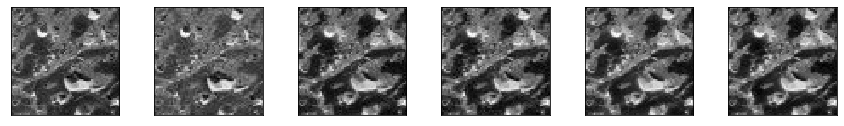

Reconstructed Pictures


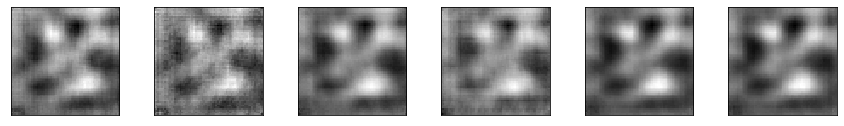

Error Map


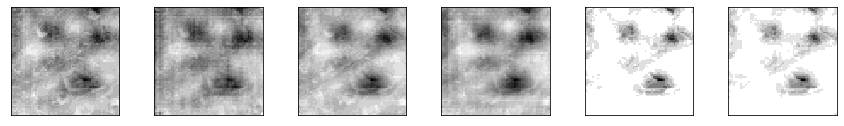


NOVEL IMAGE 1:
Original Pictures:


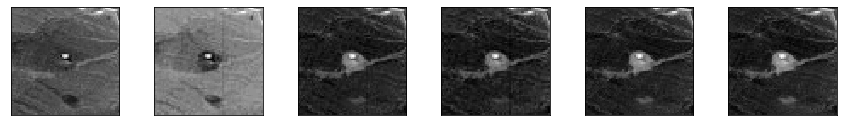

Reconstructed Pictures


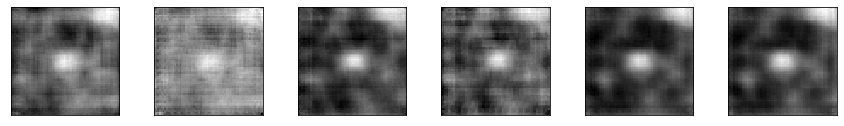

Error Map


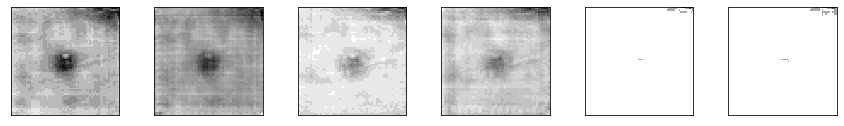

In [0]:
print('CHECK SHAPE')
print('losses_typical_img_train = ' + str(np.shape(losses_typical_img_train)))
print('losses_novel_img_train   = ' + str(np.shape(losses_novel_img_train)))
print('losses_typical_img_test  = ' + str(np.shape(losses_typical_img_test)))
print('losses_novel_img_test    = ' + str(np.shape(losses_novel_img_test)))

print('\nCHECK SIZES')
print('losses_typical_img_train = ' + str(getsizeof(losses_typical_img_train)))
print('typical_images_train     = ' + str(getsizeof(typical_images_train)))
print('losses_novel_img_train = ' + str(getsizeof(losses_novel_img_train)))
print('novel_images_train     = ' + str(getsizeof(novel_images_train)))

print('\nCHECK RANGES')
print('losses_typical_img_train: MAX  = ' + str(np.max(losses_typical_img_train)) + ';  MIN = ' + str(np.min(losses_typical_img_train)))
print('losses_novel_img_train: MAX    = ' + str(np.max(losses_novel_img_train)) + ';  MIN = ' + str(np.min(losses_novel_img_train)))
print('losses_typical_img_test: MAX   = ' + str(np.max(losses_typical_img_test)) + ';  MIN = ' + str(np.min(losses_typical_img_test)))
print('losses_novel_img_test: MAX     = ' + str(np.max(losses_novel_img_test)) + ';  MIN = ' + str(np.min(losses_novel_img_test)))

i = 1
print('\nTYPICAL IMAGE ' + str(i) + ':')
reconstruct_images(model, typical_images_train, i)
print('Error Map')
plot_images(losses_typical_img_train, i)

i = 1
print('\nNOVEL IMAGE ' + str(i) + ':')
reconstruct_images(model, novel_images_train, i)
print('Error Map')
plot_images(losses_novel_img_train, i)

Save error maps and delete other data


In [0]:
np.save('/content/drive/My Drive/SPACE_DATA/losses_typical_img_train_1.npy', losses_typical_img_train)
np.save('/content/drive/My Drive/SPACE_DATA/losses_novel_img_train_1.npy', losses_novel_img_train)
np.save('/content/drive/My Drive/SPACE_DATA/losses_typical_img_test_1.npy', losses_typical_img_test)
np.save('/content/drive/My Drive/SPACE_DATA/losses_novel_img_test_1.npy', losses_novel_img_test)

In [0]:
typical_images_train = 0
typical_images_test = 0
novel_images_train = 0
novel_images_test = 0

### Create Classifier

In [0]:
def setup_dataset(x, y):
  images = x/input_range

  batch_size = 200
  dataset = tf.data.Dataset.from_tensor_slices((images, y)).shuffle(len(images)).batch(batch_size)
  return dataset

def setup_dataset_no_shuffle(x, y):
  images = x/input_range

  batch_size = 200
  dataset = tf.data.Dataset.from_tensor_slices((images, y)).batch(batch_size)
  return dataset

In [0]:
class classifier_model(tf.keras.Model):
    def __init__(self):
        super(classifier_model, self).__init__()
        self.classifier_nn = tf.keras.models.Sequential([
                             tf.keras.layers.Input(shape = (64, 64, 6)) ,                        
                             tf.keras.layers.Conv2D(32, (5,5), padding='SAME', activation='relu'),
                             tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=2),
                             tf.keras.layers.Conv2D(64, (5,5), padding='SAME', activation='relu'),
                             tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=2),
                             tf.keras.layers.Flatten(),
                             tf.keras.layers.Dense(512, activation='relu'),
                             tf.keras.layers.Dropout(rate=0.4),
                             tf.keras.layers.Dense(1)
                             ], name='Classifier')

    def classify(self, x):
        logits = self.classifier_nn(x)
        prob   = tf.math.sigmoid(logits)
        return logits, prob

classifier = classifier_model()
classifier.classifier_nn.summary()

Model: "Classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 64, 64, 32)        4832      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 64)        51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               8389120   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0

In [0]:
def calculate_loss(model, x, y):
    logits, prob = model.classify(x)
    labels = y

    weight = len(losses_typical_img_train)/len(losses_novel_img_train)
      
    loss = tf.nn.weighted_cross_entropy_with_logits(labels = labels, logits = logits, pos_weight = weight)
    loss = tf.reduce_mean(loss)

    return loss

In [0]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)
train_loss = tf.keras.metrics.Mean(name='train_loss')
test_loss = tf.keras.metrics.Mean(name='test_loss')

In [0]:
def train_step(model, x, y, optimizer):
    with tf.GradientTape() as tape:
        loss = calculate_loss(model, x, y)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        train_loss(loss)

def test_step(model, x, y, optimizer):
    loss = calculate_loss(model, x)
    test_loss(loss)

def train_only_dataset(model, train_dataset, epochs):  
  for epoch in range(epochs):
    for train_x, train_y in train_dataset: 
      train_step(model, train_x, train_y, optimizer)

    loss = train_loss.result()
     
  train_loss.reset_states()
  return loss

### Train Classifier

In [0]:
losses_typical_img_train = np.load('/content/drive/My Drive/SPACE_DATA/losses_typical_img_train_1.npy')
losses_novel_img_train = np.load('/content/drive/My Drive/SPACE_DATA/losses_novel_img_train_1.npy')
losses_typical_img_test = np.load('/content/drive/My Drive/SPACE_DATA/losses_typical_img_test_1.npy')
losses_novel_img_test = np.load('/content/drive/My Drive/SPACE_DATA/losses_novel_img_test_1.npy')

In [0]:
N_typical_images_train = losses_typical_img_train.shape[0]
N_typical_images_test = losses_typical_img_test.shape[0]
N_novel_images_train = losses_typical_img_test.shape[0]
N_novel_images_test = losses_novel_img_test.shape[0]
img_height = losses_typical_img_train.shape[1]
img_width = losses_typical_img_train.shape[2]
img_channels = losses_typical_img_train.shape[3]
input_range = 255

In [0]:
classifier = classifier_model()

9.90---> 0.7321819


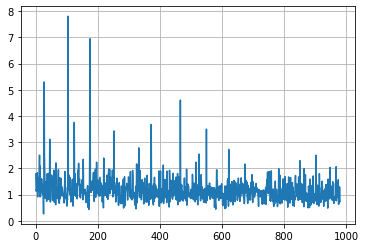

TRAINING TIME = 400.13669204711914



In [0]:
start_time = time.time()

losses = []
train_data = np.append(losses_novel_img_train, losses_typical_img_train, axis=0)
train_labels = np.zeros([len(train_data), 1])
train_labels[0:300, 0] = 1

for j in range(10):
  train_data, train_labels = shuffle(train_data, train_labels, random_state=0)
  print(j)
  for i in range(99):
    dataset = setup_dataset(train_data[i*1000:i*1000+1000].astype('float32'), train_labels[i*1000:i*1000+1000].astype('float32'))
    loss = train_only_dataset(classifier, dataset, 1)
    losses = np.append(losses, loss.numpy())

    if i%10 == 0:  
      clear_output()
      print(str(j) + '.' + str(i) + '---> ' + str(loss.numpy()))
      plt.plot(range(len(losses)), losses)
      plt.grid(which='both', axis='both')
      plt.show()
print('TRAINING TIME = {}\n'.format(time.time()-start_time))

### Test classifier

In [0]:
logits, prob = classifier.classify(np.append(losses_novel_img_test.astype('float32'), losses_typical_img_test.astype('float32'), axis=0))
y_true = np.zeros([len(prob),]).astype('int')
y_true[0:32] = 1
logits = np.array(logits[:,0]).astype('int')

print(y_true)
print(logits)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ -245   193   391  -170   282   -30   181  -225   256   142   144   208
   108  -234  -241   -17  -112   258  -213    86 -1281  -227   -80    27
   124   167   268   131  -100    23 -2652   324 -1780  -375    16 -1710
 -1283 -1476    85 -1951   -74    82 -2086   119 -1732    77  -863    -8
    97   -54   -59  -225 -2173    70    70   261 -2378 -5527  -359  -688
   128   119 -1472  -375  -463 -1268   143 -1992 -2486  -253   119    11
  -422 -1778 -2133   171   147 -2845 -1233 -1651    62  -903 -1372  -500
 -2388  -643 -2047    99  -239  -740 -1377 -1504   -43 -2652  -324    50
    80     0   178 -1613  -276    12   225    86 -1831  -997  -937 -1892
    97    78    93   -72   -87  -555 -1017    84  -616   116    79 -1164
 

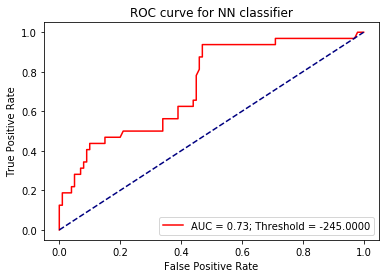

-245
-245
[0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1.
 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1.
 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1.
 1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 0.
 0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 0.]
[[53. 47.]
 [ 3. 29.]]


In [0]:
auc_value, threshold_value, _, _, _, threshold_avg_value = threshold_ROC(y_true, logits, 'NN classifier', plot=True)
y_predicted = np.zeros([len(y_true),])
y_predicted[np.where(logits > threshold_value)] = 1 

table_of_counts = np.zeros([2,2])
for j in range(len(y_true),):
  if y_true[j] == 0:
    if y_predicted[j] == 0:
      table_of_counts[0,0] += 1
    else: table_of_counts[0,1] += 1
  if y_true[j] == 1:
    if y_predicted[j] == 0:
      table_of_counts[1,0] += 1
    else: table_of_counts[1,1] += 1

true_positive = table_of_counts[1,1]
false_positive = table_of_counts[0,1]
true_negative = table_of_counts[0,0]
false_negative = table_of_counts[1,0]

accuracy = (true_positive+true_negative)/len(y_true)
avg_accuracy = np.mean([true_positive/(true_positive+false_negative),true_negative/(true_negative+false_positive)])
print(threshold_value)
print(threshold_avg_value)
print(y_predicted)
print(table_of_counts)

In [0]:
result_table = np.empty([1,6])
index = ['_']*1
result_table[0,0] = "{0:.1f}".format(accuracy*100)
result_table[0,1] = "{0:.1f}".format(avg_accuracy*100)
result_table[0,2] = table_of_counts[1,1].astype('int')
result_table[0,3] = table_of_counts[0,1].astype('int')
result_table[0,4] = table_of_counts[0,0].astype('int')
result_table[0,5] = table_of_counts[1,0].astype('int')
index = 'Loss_1'
df = pd.DataFrame(result_table, columns = ['Accuracy', 'Avg_accuracy', 'True Pos.', 'False Pos.', 'True Neg.', 'False Neg.',])
df.astype(str).replace('\.0', '', regex=True)

,Accuracy,Avg_accuracy,True Pos.,False Pos.,True Neg.,False Neg.
0,62.1,71.8,29,47,53,3
